# Clustering

In [200]:
import pandas as pd
import hdbscan
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [201]:
dataset = pd.read_csv('../data/preprocessed_data.csv')

In [202]:
columns_for_clustering = [
    'marital_status', 
    'have_children', 
    'status', 'province', 
    'site_001', 'site_type', 'assessment_modality', 'respondent_gender', 'are_you_headhh',
    'male_0_6',
    'male_7_14','male_15_17','male_18_59','male_60',
    'female_0_6','female_7_14','female_15_17','female_18_59','female_60',
    'hh_info_person_health'
    ,'hh_info_legal_needs','hh_info_school_dropout','hh_info_unable_work',
    'hh_info_child_armed_group','hh_info_family_unity','hh_info_drug_dependence'
]
df = dataset


In [203]:
# Seleccionamos todas las columnas excepto el ID si lo tienes
df_processed = df.drop(columns=['pseudo_id'], errors='ignore')

# Convertimos categóricas a numéricas
df_processed = pd.get_dummies(df_processed, drop_first=True)

# Rellenamos NaNs
df_processed = df_processed.fillna(0)


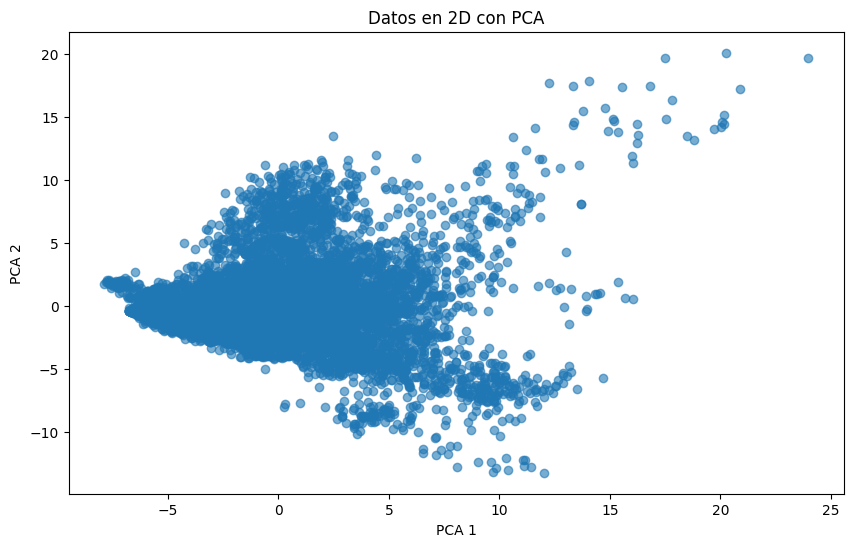

In [204]:
from sklearn.decomposition import PCA

# Solo columnas numéricas
numeric_cols = df.select_dtypes(include='number').columns
X = StandardScaler().fit_transform(df[numeric_cols])

# Reducir a 2D
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

plt.figure(figsize=(10,6))
plt.scatter(X_pca[:,0], X_pca[:,1], alpha=0.6)
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('Datos en 2D con PCA')
plt.show()

In [205]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=60, min_samples=5)
df['cluster'] = clusterer.fit_predict(df_processed)

c:\Users\xanet\.conda\envs\ai25\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\xanet\.conda\envs\ai25\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [206]:
pca = PCA(n_components=2)
components = pca.fit_transform(df_processed)
df['pca1'] = components[:,0]
df['pca2'] = components[:,1]


C:\Users\xanet\AppData\Local\Temp\ipykernel_21600\3175880550.py:23: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('viridis', n_clusters)  # gradiente continuo


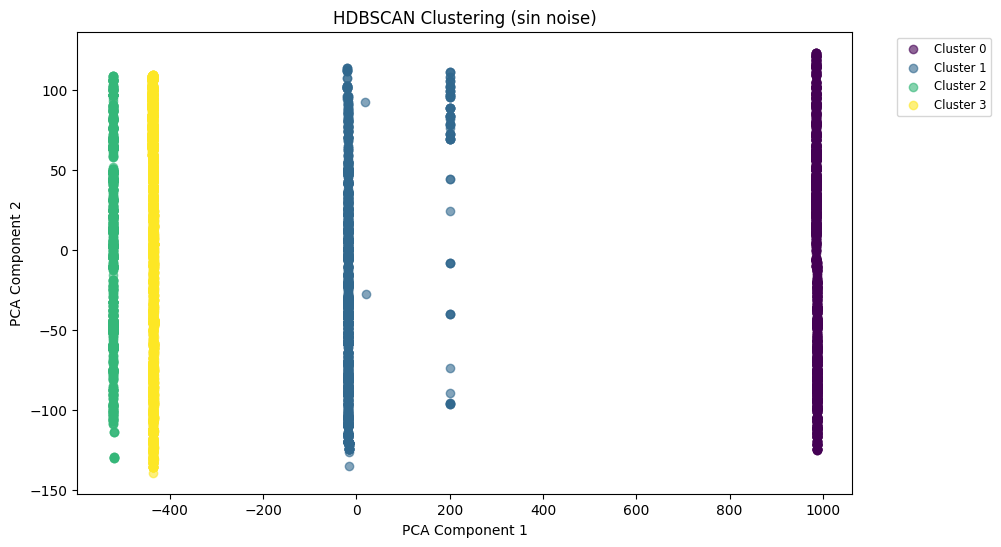

In [207]:
# plt.figure(figsize=(10,6))
# palette = plt.cm.get_cmap('tab20', len(set(df['cluster'])))

# for cluster in set(df['cluster']):
#     subset = df[df['cluster'] == cluster]
#     color = 'grey' if cluster == -1 else palette(cluster)
#     label = 'Noise' if cluster == -1 else f'Cluster {cluster}'
#     plt.scatter(subset['pca1'], subset['pca2'], label=label, alpha=0.6)

# plt.xlabel('PCA Component 1')
# plt.ylabel('PCA Component 2')
# plt.title('HDBSCAN Clustering')
# plt.legend()
# plt.show()

import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10,6))

clusters = sorted([c for c in set(df['cluster']) if c != -1])
n_clusters = len(clusters)
cmap = plt.cm.get_cmap('viridis', n_clusters)  # gradiente continuo

for i, cluster in enumerate(clusters):
    subset = df[df['cluster'] == cluster]
    color = cmap(i / n_clusters)  # interpolar en el gradiente
    plt.scatter(subset['pca1'], subset['pca2'], color=color, label=f'Cluster {cluster}', alpha=0.6)

plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('HDBSCAN Clustering (sin noise)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')  # leyenda fuera
plt.show()

In [ ]:
# calcula columnas más representativas por cluster (z-score vs media global)
features = df_processed.columns
global_mean = df_processed.mean()
global_std = df_processed.std().replace(0, 1e-6)  # evitar divisiones por 0
top_n = 5  # cambia si quieres más/menos

top_per_cluster = {}

for cluster in sorted([c for c in df['cluster'].unique() if c != -1]):
    cluster_mean = df_processed.loc[mask, features].mean()
    cluster_std  = df_processed.loc[mask, features].std().replace(0, 1e-6)
    global_mean  = df_processed.mean()
    global_std   = df_processed.std().replace(0, 1e-6)

    z_diff = (cluster_mean - global_mean) / global_std
    pooled_std = np.sqrt((cluster_std**2 + global_std**2) / 2)
    cohen_d = (cluster_mean - global_mean) / pooled_std

    top = z_diff.abs().sort_values(ascending=False).head(top_n)
    results = pd.DataFrame({
        'z_diff': z_diff[top.index],
        'cohen_d': cohen_d[top.index],
        'cluster_mean': cluster_mean[top.index],
        'global_mean': global_mean[top.index],
        'direction': ['higher in cluster' if z_diff[f] > 0 else 'lower in cluster' for f in top.index],
        'cluster_size': mask.sum()
    })
    display(results.style.format({'z_diff':'{:.2f}','cohen_d':'{:.2f}','cluster_mean':'{:.3f}','global_mean':'{:.3f}'}))

# opcional: concatenar todo en un único DataFrame
top_summary = pd.concat({k: v for k, v in top_per_cluster.items()}, names=['cluster','feature'])
top_summary.head(50)


,z_diff,cohen_d,cluster_mean,global_mean,direction,cluster_size
weight,-0.60,-0.85,90.980,526.870,lower in cluster,3618
idp_when_were_you_displaced,0.53,0.75,4.000,3.457,higher in cluster,3618
status,0.53,0.58,3.836,2.971,higher in cluster,3618
idp_do_you_inten_tionmove_onward,-0.47,-0.66,0.000,0.462,lower in cluster,3618
displaced_armed_conflict,0.36,0.51,1.000,0.884,higher in cluster,3618


In [208]:
correlations = df.corr()['cluster'].sort_values(key=abs, ascending=False)
print(correlations)


cluster                             1.000000
pca1                               -0.778103
weight                             -0.777990
idp_when_were_you_displaced         0.740506
idp_do_you_inten_tionmove_onward   -0.652956
                                      ...   
which_members_lackdocumentati_4     0.000215
sending_boys_are_they_engag_w_1    -0.000107
interviewtype                            NaN
intendingreturnmove_explosive_1          NaN
intendingreturnmove_explosive            NaN
Name: cluster, Length: 366, dtype: float64


c:\Users\xanet\.conda\envs\ai25\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\xanet\.conda\envs\ai25\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\xanet\AppData\Local\Temp\ipykernel_21600\2349009873.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_numeric['microcluster'] = clusterer.fit_predict(df_scaled)
C:\Users\xanet\AppData\Local\Temp\ipykernel_21600\2349009873.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

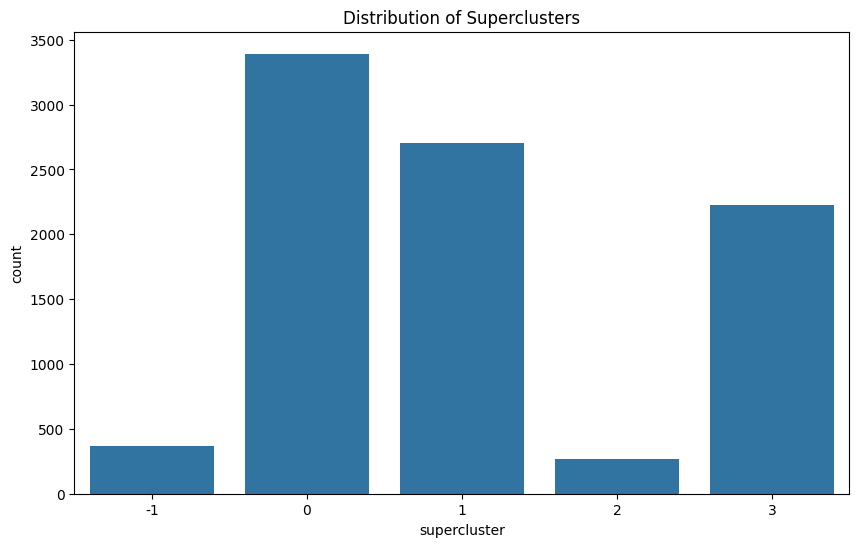

In [ ]:
import pandas as pd
import hdbscan
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

# Leer dataset
dataset = pd.read_csv('../data/preprocessed_data.csv')

# Columnas que quieres usar para clustering
columns_for_clustering = [
    'male_0_6','male_7_14','male_15_17','male_18_59','male_60',
    'female_0_6','female_7_14','female_15_17','female_18_59','female_60',
    'hh_info_person_health','hh_info_legal_needs','hh_info_school_dropout',
    'hh_info_unable_work','hh_info_child_armed_group','hh_info_family_unity',
    'hh_info_drug_dependence'
]

df_numeric = dataset[columns_for_clustering]

# Escalamos
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_numeric)

# HDBSCAN microclusters
clusterer = hdbscan.HDBSCAN(min_cluster_size=75, min_samples=5)
df_numeric['microcluster'] = clusterer.fit_predict(df_scaled)

# Excluir ruido
clustered_data = df_numeric[df_numeric['microcluster'] != -1]

# Calcular centroides de microclusters
centroids = clustered_data.groupby('microcluster').mean()

# Normalizar centroides
centroids_scaled = scaler.fit_transform(centroids)

# KMeans para superclusters
kmeans = KMeans(n_clusters=4, random_state=42)
supercluster_labels = kmeans.fit_predict(centroids_scaled)

# Mapping microcluster -> supercluster
micro_to_super = dict(zip(centroids.index, supercluster_labels))
df_numeric['supercluster'] = df_numeric['microcluster'].apply(
    lambda x: -1 if x == -1 else micro_to_super[x]
)

# Visualizar
plt.figure(figsize=(10,6))
sns.countplot(x='supercluster', data=df_numeric)
plt.title("Distribution of Superclusters")
plt.show()


c:\Users\xanet\.conda\envs\ai25\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
c:\Users\xanet\.conda\envs\ai25\Lib\site-packages\umap\spectral.py:548: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(


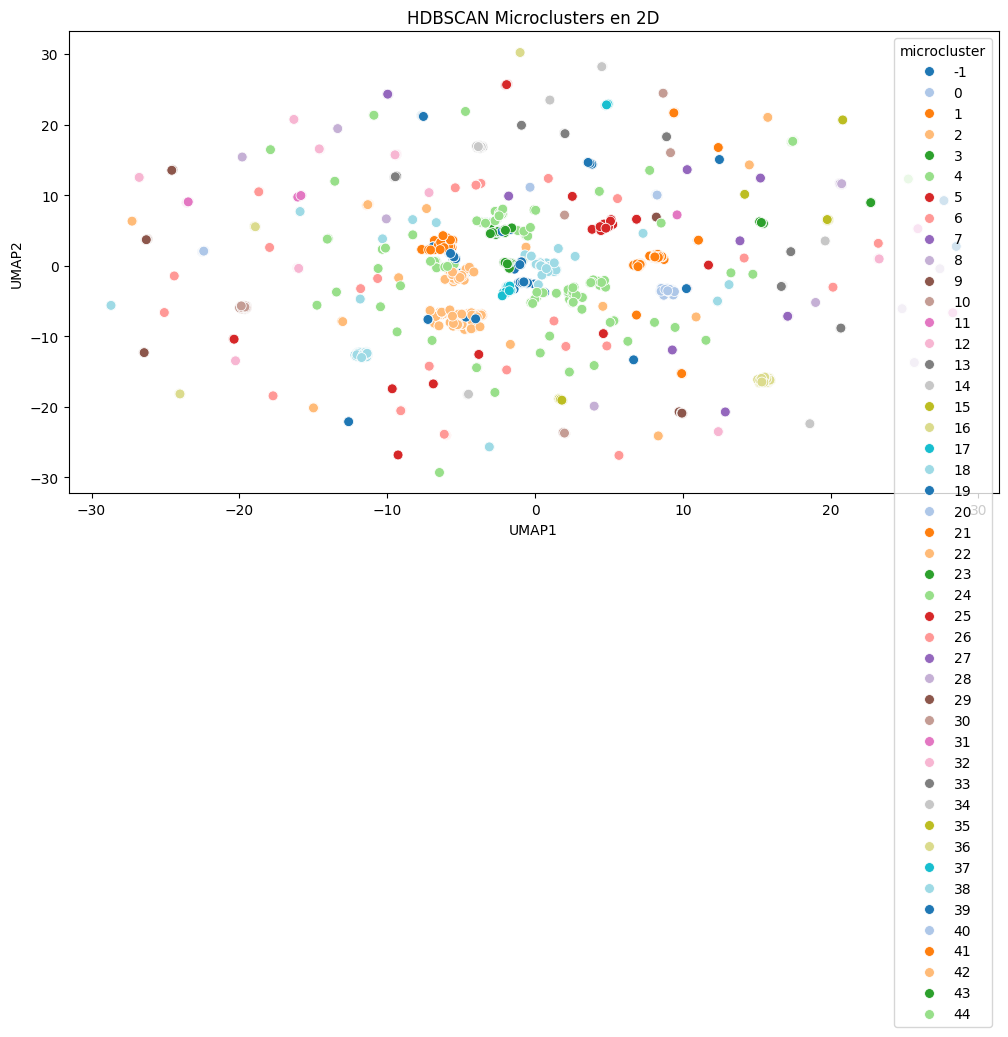

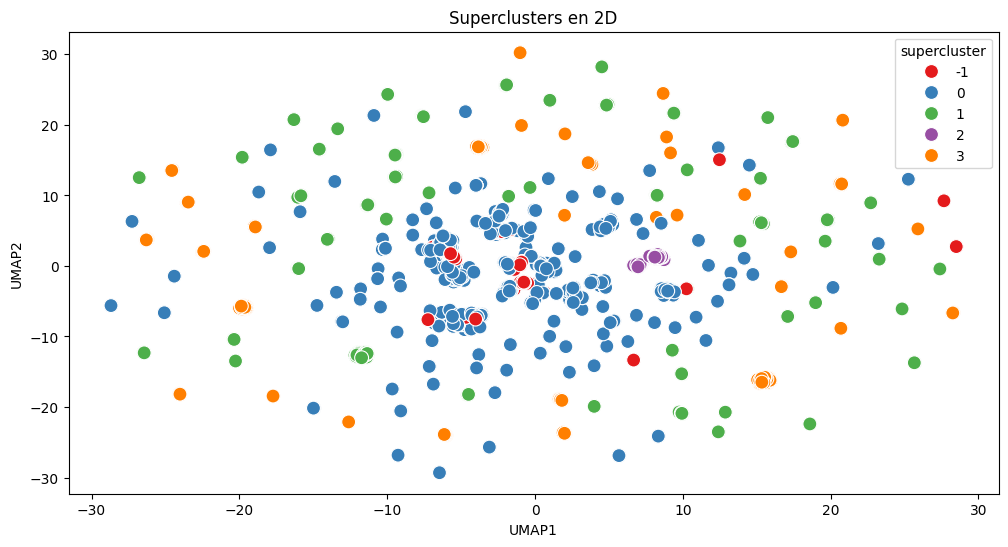

In [210]:
import umap
import matplotlib.pyplot as plt
import seaborn as sns

# Reducir a 2 dimensiones usando UMAP
reducer = umap.UMAP(n_components=2, random_state=42)
embedding = reducer.fit_transform(df_scaled)  # df_scaled es tu dataset numérico escalado

# Crear un DataFrame para plotear
plot_df = pd.DataFrame()
plot_df['UMAP1'] = embedding[:, 0]
plot_df['UMAP2'] = embedding[:, 1]
plot_df['microcluster'] = df_numeric['microcluster'].values
plot_df['supercluster'] = df_numeric['supercluster'].values

# Scatter plot para microclusters
plt.figure(figsize=(12,6))
sns.scatterplot(
    x='UMAP1', y='UMAP2',
    hue='microcluster',  # Cambia por 'supercluster' si quieres ver los grupos grandes
    palette='tab20',
    data=plot_df,
    legend='full',
    s=50
)
plt.title('HDBSCAN Microclusters en 2D')
plt.show()

# Scatter plot para superclusters
plt.figure(figsize=(12,6))
sns.scatterplot(
    x='UMAP1', y='UMAP2',
    hue='supercluster',
    palette='Set1',
    data=plot_df,
    legend='full',
    s=100
)
plt.title('Superclusters en 2D')
plt.show()
